In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import pdb
import sys
sys.path.append('..')
from template import utils, utils_v2

In [2]:
utils.set_random_seeds()

In [3]:
torch.use_deterministic_algorithms(False)

In [15]:
# setting config
config = yaml.safe_load(open("config.yaml"))
print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [5]:
LFWPeople_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [6]:
train_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="train",download=True)
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(f"train set size: {len(train_dataset)}")
print(f"validation set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 9525
validation set size: 1854
test set size: 1854


In [8]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        self._clean_singular_anchors()
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.dataset)
    
    def _clean_singular_anchors(self):
        """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
        """
        singular_anchors = []
        for i in range(len(self.dataset)):
            _ , anchor_lbl = self.dataset[i]
            pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
            if isinstance(pos_ids, np.int64):
                singular_anchors.append(i)

        self.dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
        self.labels = torch.Tensor([l for _,l in self.dataset])
        self.arange = np.arange(len(self.dataset))

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.dataset[i]
        
        
        # lists for positives and negatives
        pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.
        
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()
        pos_img, pos_lbl = self.dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [9]:
tri_train_dataset = TripletDataset(train_dataset)
tri_val_dataset = TripletDataset(val_dataset)
tri_test_dataset = TripletDataset(test_dataset)

There may be more subtle way to get rid of single "no positive faces except anchor" problem, f.e. making use of them in negative samples but we will try this approach in the beggining.

In [11]:
print(f"train set size after cleanup: {len(tri_train_dataset)}")
print(f"validation set size after cleanup: {len(tri_val_dataset)}")
print(f"test set size after cleanup: {len(tri_test_dataset)}")

train set size after cleanup: 6671
validation set size after cleanup: 1110
test set size after cleanup: 1065


In [16]:
def clip_img(img):
    maxValue = np.amax(img)
    minValue = np.amin(img)
    img = np.clip(img, 0, 1)
    return img

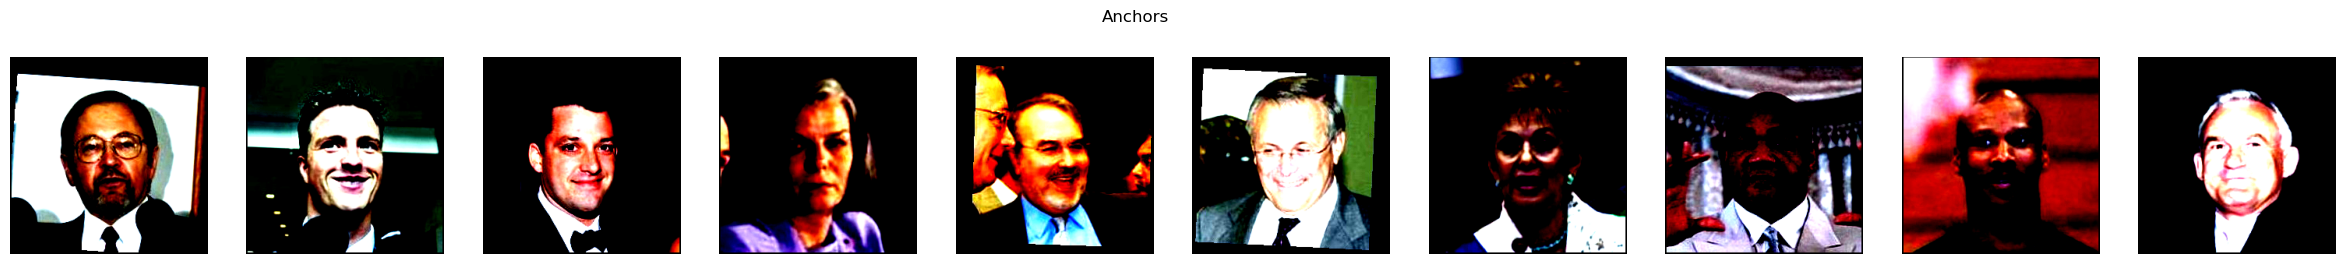

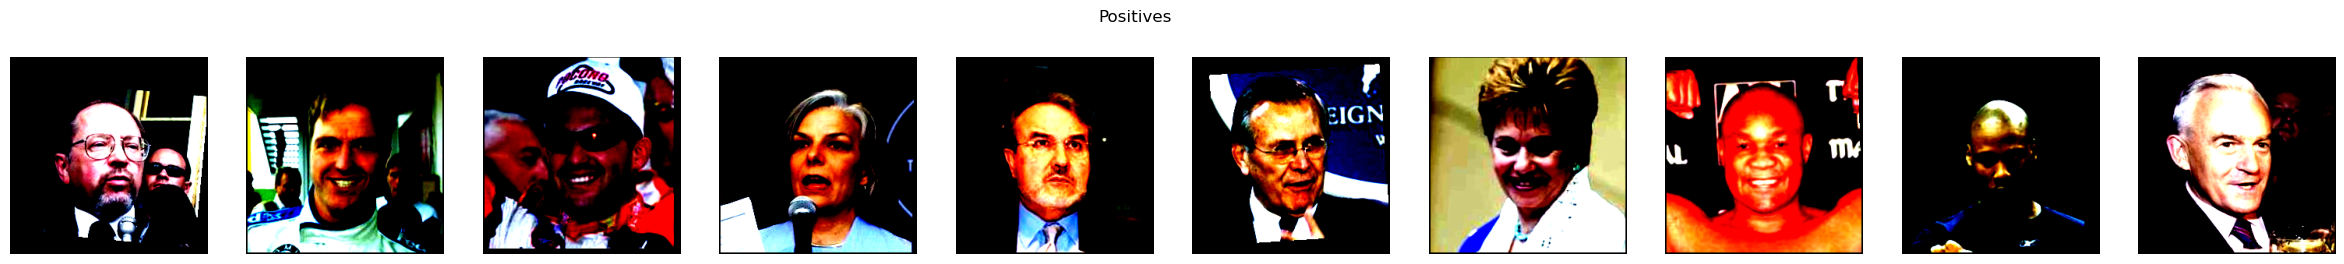

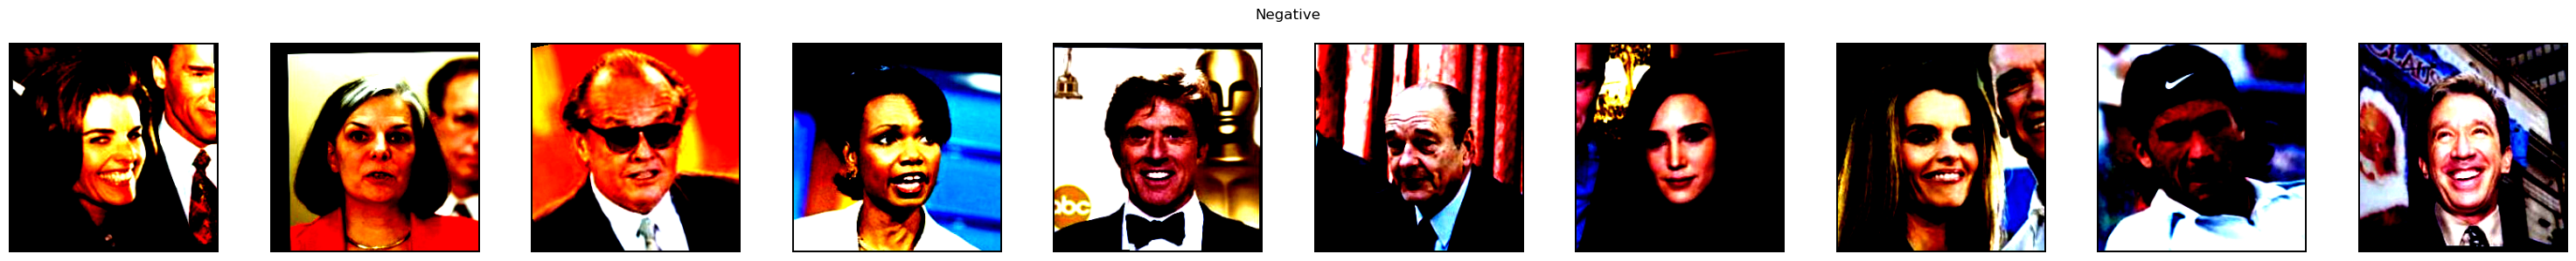

In [17]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    try:
        (anchor, positive, negative), _ = tri_val_dataset[i]
        anchor = anchor.numpy().reshape(3,254,254).transpose(1, 2, 0)
        positive = positive.numpy().reshape(3,254,254).transpose(1, 2, 0)
        negative = negative.numpy().reshape(3,254,254).transpose(1, 2, 0)
        anchor = clip_img(anchor)
        positive = clip_img(positive)
        negative = clip_img(negative)
        anchors[i].imshow(anchor)
        anchors[i].axis("off")
        positives[i].imshow(positive)
        positives[i].axis("off")
        negatives[i].imshow(negative)
        negatives[i].axis("off")
    except ValueError:
        continue
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [18]:
batch_size = int(config["BATCH_SIZE"])

In [19]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=batch_size, shuffle=False) 

## Siamese model

In [20]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [21]:
class SiameseModel(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, in_spatial=(32, 32)):
        """ Module initializer """
        super().__init__()
        
        # convolutional feature extractor
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # fully connected embedder
        self.fc = nn.Linear(512, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.resnet(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        # is there a more efficient way?
        # imgs = torch.concat([anchor, positive, negative], dim=0)
        # embs = self.forward_one(imgs)
        # anchor_emb, positive_emb, negative_emb = torch.chunk(embs, 3, dim=0)
        
        return anchor_emb, positive_emb, negative_emb

In [22]:
model = SiameseModel()

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print(f"Model has {utils_v2.count_model_params(model)} parameters")
model

Model has 11192928 parameters


SiameseModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## Training
Triplet loss and Trainer shall initially remain unchanged

In [24]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [25]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [26]:
criterion = TripletLoss(margin=0.2)

In [27]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=1000)

In [28]:
trainer.fit()

Train Iter 0: Loss=0.14903):   0%|                                                             | 0/1000 [00:02<?, ?it/s]

Valid loss @ iteration 0: Loss=0.09704980585310194


Train Iter 250: Loss=0.01169):   0%|                                                           | 0/1000 [00:59<?, ?it/s]

Valid loss @ iteration 250: Loss=0.02569799076041414


Train Iter 500: Loss=0.0086):   0%|                                                            | 0/1000 [01:56<?, ?it/s]

Valid loss @ iteration 500: Loss=0.03075734893273976


Train Iter 640: Loss=0.01721):   0%|                                                           | 0/1000 [02:29<?, ?it/s]

KeyboardInterrupt: 